# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# Vanilla RNN Implementation

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:

def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}    
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2692, Accuracy: 0.9110, F1: 0.6291
Validation: Loss: 0.1779, Accuracy: 0.9394, F1: 0.7533
Epoch 2/10
Training: Loss: 0.1883, Accuracy: 0.9348, F1: 0.7611
Validation: Loss: 0.1676, Accuracy: 0.9408, F1: 0.7625
Epoch 3/10
Training: Loss: 0.1688, Accuracy: 0.9405, F1: 0.7867
Validation: Loss: 0.1638, Accuracy: 0.9435, F1: 0.7754
Epoch 4/10
Training: Loss: 0.1544, Accuracy: 0.9442, F1: 0.8033
Validation: Loss: 0.1644, Accuracy: 0.9440, F1: 0.7787
Epoch 5/10
Training: Loss: 0.1432, Accuracy: 0.9483, F1: 0.8206
Validation: Loss: 0.1652, Accuracy: 0.9442, F1: 0.7813
Epoch 6/10
Training: Loss: 0.1320, Accuracy: 0.9517, F1: 0.8342
Validation: Loss: 0.1657, Accuracy: 0.9416, F1: 0.7706
Epoch 7/10
Training: Loss: 0.1213, Accuracy: 0.9548, F1: 0.8476
Validation: Loss: 0.1676, Accuracy: 0.9423, F1: 0.7726
Epoch 8/10
Training: Loss: 0.1118, Accuracy: 0.9597, F1: 0.8650
Validation: Loss: 0.1707, Accuracy: 0.9428, F1: 0.7744
Epoch 9/10
Training: Loss: 0.1038, Accuracy: 0.9

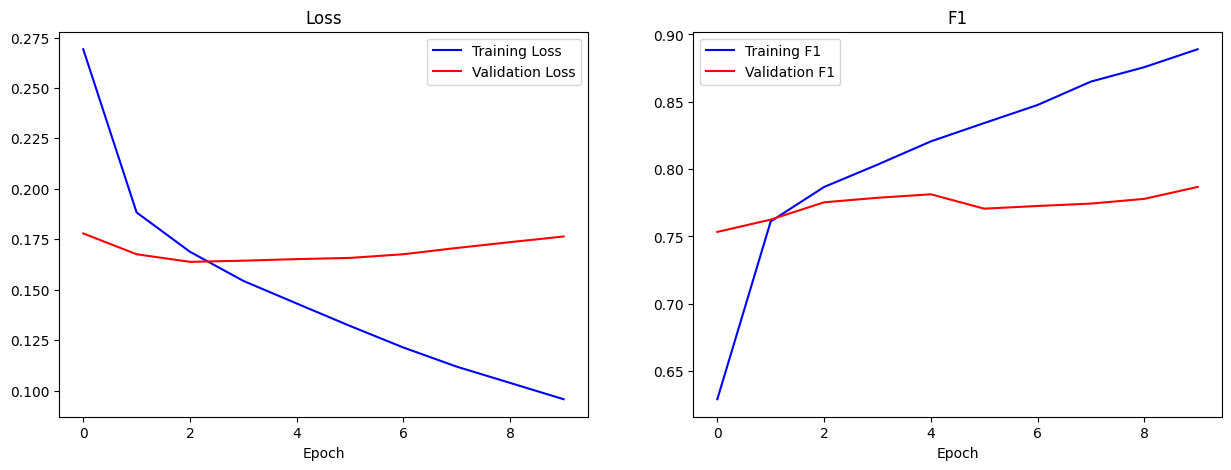

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
torch.save(rnn_word2vec_model, "t2_model1_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t2_model1_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2694122694122694, 1: 0.22038567493112948, 2: 0.3290229885057471}
Labelwise Accuracy Scores:
{0: 0.6781857451403888, 1: 0.49382716049382713, 2: 0.9744680851063829}
Vaniila RNN with Word2Vec ==> Accuracy: 0.9254, F1: 0.7594


# For GloVe Embeddings

In [13]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.2922, Accuracy: 0.9117, F1: 0.6091
Validation: Loss: 0.2176, Accuracy: 0.9301, F1: 0.6733
Epoch 2/10
Training: Loss: 0.2276, Accuracy: 0.9278, F1: 0.7127
Validation: Loss: 0.2051, Accuracy: 0.9339, F1: 0.7030
Epoch 3/10
Training: Loss: 0.2045, Accuracy: 0.9340, F1: 0.7414
Validation: Loss: 0.2035, Accuracy: 0.9358, F1: 0.7112
Epoch 4/10
Training: Loss: 0.1841, Accuracy: 0.9390, F1: 0.7641
Validation: Loss: 0.2031, Accuracy: 0.9380, F1: 0.7208
Epoch 5/10
Training: Loss: 0.1660, Accuracy: 0.9453, F1: 0.7925
Validation: Loss: 0.2030, Accuracy: 0.9396, F1: 0.7277
Epoch 6/10
Training: Loss: 0.1509, Accuracy: 0.9504, F1: 0.8150
Validation: Loss: 0.2041, Accuracy: 0.9377, F1: 0.7234
Epoch 7/10
Training: Loss: 0.1374, Accuracy: 0.9545, F1: 0.8310
Validation: Loss: 0.2109, Accuracy: 0.9382, F1: 0.7298
Epoch 8/10
Training: Loss: 0.1247, Accuracy: 0.9598, F1: 0.8533
Validation: Loss: 0.2186, Accuracy: 0.9377, F1: 0.7270
Epoch 9/10
Training: Loss: 0.1148, Accuracy: 0.9636, F1: 0.

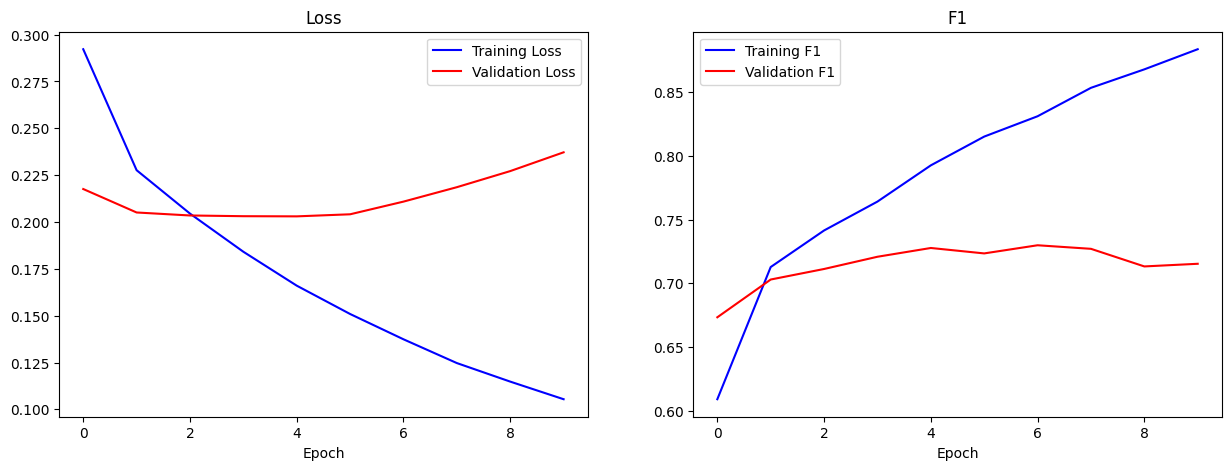

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
torch.save(rnn_glove_model, "t2_model1_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t2_model1_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.22254196642685853, 1: 0.17276422764227642, 2: 0.32913784631666476}
Labelwise Accuracy Scores:
{0: 0.5010799136069114, 1: 0.3497942386831276, 2: 0.9751399776035834}
Vaniila RNN with GloVe ==> Accuracy: 0.9033, F1: 0.6633


# For FastText Embeddings

In [18]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2840, Accuracy: 0.9119, F1: 0.6028
Validation: Loss: 0.1833, Accuracy: 0.9322, F1: 0.6939
Epoch 2/10
Training: Loss: 0.1875, Accuracy: 0.9321, F1: 0.7440
Validation: Loss: 0.1699, Accuracy: 0.9401, F1: 0.7374
Epoch 3/10
Training: Loss: 0.1683, Accuracy: 0.9381, F1: 0.7725
Validation: Loss: 0.1643, Accuracy: 0.9435, F1: 0.7483
Epoch 4/10
Training: Loss: 0.1559, Accuracy: 0.9427, F1: 0.7918
Validation: Loss: 0.1629, Accuracy: 0.9432, F1: 0.7532
Epoch 5/10
Training: Loss: 0.1458, Accuracy: 0.9448, F1: 0.8004
Validation: Loss: 0.1649, Accuracy: 0.9428, F1: 0.7489
Epoch 6/10
Training: Loss: 0.1366, Accuracy: 0.9479, F1: 0.8126
Validation: Loss: 0.1686, Accuracy: 0.9411, F1: 0.7413
Epoch 7/10
Training: Loss: 0.1277, Accuracy: 0.9511, F1: 0.8256
Validation: Loss: 0.1736, Accuracy: 0.9404, F1: 0.7348
Epoch 8/10
Training: Loss: 0.1192, Accuracy: 0.9542, F1: 0.8386
Validation: Loss: 0.1795, Accuracy: 0.9384, F1: 0.7230
Epoch 9/10
Training: Loss: 0.1115, Accuracy: 0.9

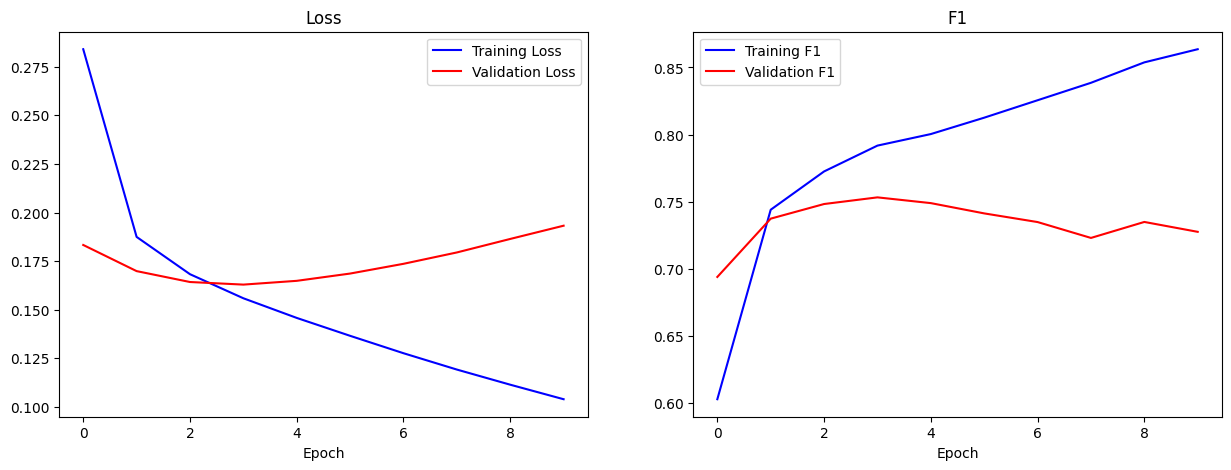

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
torch.save(rnn_fasttext_model, "t2_model1_fasttext.pt")

In [22]:
test_accuracy, test_f1 = test("t2_model1_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2517921146953405, 1: 0.19980787704130643, 2: 0.33013001695873373}
Labelwise Accuracy Scores:
{0: 0.6069114470842333, 1: 0.4279835390946502, 2: 0.9809630459126539}
Vaniila RNN with FastText ==> Accuracy: 0.9215, F1: 0.7298
